Étape 1 – Importation des bibliothèques et lecture d'une image

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


def show_image(path):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(os.path.basename(path))
    plt.axis('off')
    plt.show()

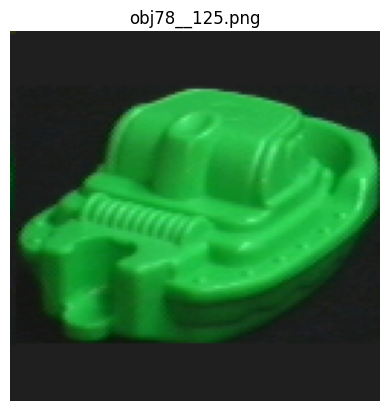

In [4]:
image_path = "coil-100/obj78__125.png"  # Afficher une image exemple
show_image(image_path)


Étape 2 – Calcul de l’histogramme RVB réduit

In [5]:

def extract_color_histogram(image_path, bins=32):
    image = cv2.imread(image_path)
    
    if image is None:
        raise FileNotFoundError(f"Image non trouvée : {image_path}")

    histogram = []

    # Pour chaque canal B, G, R
    for i in range(3):
        hist = cv2.calcHist([image], [i], None, [bins], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        histogram.extend(hist)

    return np.array(histogram)


Test sur une image

In [6]:
hist = extract_color_histogram(image_path)
print(f"Histogram shape: {hist.shape}")  
print(hist[:10])  # aperçu des premières valeurs


Histogram shape: (96,)
[0.00289075 0.02381978 0.15066588 0.9512879  0.09504785 0.07747209
 0.06498405 0.0967823  0.1060327  0.14361244]


Étape 3 – Extraction des moments de Hu

In [7]:

def extract_hu_moments(image_path):
    image = cv2.imread(image_path)
    
    if image is None:
        raise FileNotFoundError(f"Image non trouvée : {image_path}")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    moments = cv2.moments(gray)
    hu_moments = cv2.HuMoments(moments).flatten()

    # Transformation logarithmique pour les moments de Hu (standard pour stabiliser les valeurs)
    for i in range(len(hu_moments)):
        hu_moments[i] = -1 * np.sign(hu_moments[i]) * np.log10(abs(hu_moments[i]) + 1e-10)

    return hu_moments


 Test sur  l'image

In [8]:
hu = extract_hu_moments(image_path)
print(f"Moments de Hu : {hu.shape}") 
print(hu)


Moments de Hu : (7,)
[  2.76616868   7.14547085   9.9612807    9.89447993  10.
   9.99997499 -10.        ]


Étape 4 – Fonction complète extract_features()

In [9]:
def extract_features(image_path):
    color_hist = extract_color_histogram(image_path)
    hu_moments = extract_hu_moments(image_path)
    
    return {
        "hist": color_hist,
        "hu": hu_moments
    }


Test de la fonction globale

In [10]:
features = extract_features(image_path)
print(f"Taille histogramme : {features['hist'].shape}") 
print(f"Taille moments de Hu : {features['hu'].shape}")  


Taille histogramme : (96,)
Taille moments de Hu : (7,)


Étape 5 – Fonction compute_distance()

In [11]:
def compute_distance(f1, f2, w1=0.5, w2=0.5):
    # Distance Chi-2 pour les histogrammes
    hist_dist = cv2.compareHist(f1['hist'].astype('float32'), f2['hist'].astype('float32'), cv2.HISTCMP_CHISQR)

    # Distance euclidienne pour les moments de Hu
    hu_dist = np.linalg.norm(f1['hu'] - f2['hu'])

    # Distance globale pondérée
    return w1 * hist_dist + w2 * hu_dist


Test sur 2 images

In [12]:
img1 = "coil-100/obj9__0.png"
img2 = "coil-100/obj95__230.png"

f1 = extract_features(img1)
f2 = extract_features(img2)

distance = compute_distance(f1, f2)
print(f"Distance entre {os.path.basename(img1)} et {os.path.basename(img2)} : {distance:.4f}")


Distance entre obj9__0.png et obj95__230.png : 15.9424


Étape 6 – Recherche des N images les plus proches

In [13]:
def search_similar_images(query_path, base_folder, N=5):
    query_features = extract_features(query_path)
    results = []

    for fname in os.listdir(base_folder):
        img_path = os.path.join(base_folder, fname)
        if img_path == query_path or not fname.lower().endswith((".ppm", ".jpg", ".png")):
            continue

        features = extract_features(img_path)
        dist = compute_distance(query_features, features)
        results.append((fname, dist))

    results.sort(key=lambda x: x[1])

    print("Image\t\tDistance")
    for fname, dist in results[:N]:
        print(f"{fname}\t{dist:.4f}")


Test de la recherche avec une image de requête

In [14]:
search_similar_images("coil-100/obj9__0.png", "coil-100", N=5)


Image		Distance
obj9__355.png	0.0814
obj9__5.png	0.0997
obj9__10.png	0.2019
obj9__350.png	0.2115
obj9__275.png	0.8052


Étape 7 – Sauvegarder les descripteurs dans un fichier 

In [15]:
def precalculate_features(base_folder, save_path="features.npz"):
    features_dict = {}

    for fname in os.listdir(base_folder):
        if fname.lower().endswith((".ppm", ".jpg", ".png")):
            path = os.path.join(base_folder, fname)
            feats = extract_features(path)
            features_dict[fname] = feats

    # On sépare hist et hu pour la sauvegarde
    np.savez_compressed(save_path,
        filenames=list(features_dict.keys()),
        hists=np.array([v["hist"] for v in features_dict.values()]),
        hus=np.array([v["hu"] for v in features_dict.values()])
    )

    print(f"Descripteurs sauvegardés dans {save_path}")


In [16]:
precalculate_features("coil-100")


Descripteurs sauvegardés dans features.npz


# Application de k-means

Étape 1 – Charger les descripteurs et extraire les vrais labels

In [17]:
from sklearn.preprocessing import LabelEncoder

# Charger les descripteurs
def load_features(feature_path="features.npz"):
    data = np.load(feature_path, allow_pickle=True)
    filenames = data["filenames"]
    hists = data["hists"]
    hus = data["hus"]

    X = np.hstack((hists, hus))  # concaténer couleur + forme
    labels = [fname.split("__")[0] for fname in filenames] 

    encoder = LabelEncoder()
    y = encoder.fit_transform(labels)  

    return X, y, filenames, encoder


In [18]:
X, y, filenames, encoder = load_features()
print(f"Descripteurs shape: {X.shape}, Nb classes: {len(set(y))}")


Descripteurs shape: (7200, 103), Nb classes: 100


Étape 2 – Appliquer KMeans

In [19]:
from sklearn.cluster import KMeans

#  KMeans 
def apply_kmeans(X, n_clusters=100, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
    y_pred = kmeans.fit_predict(X)
    return y_pred


Test sur les descripteurs extraits

In [20]:
y_pred = apply_kmeans(X, n_clusters=len(set(y)))
print(f"Clusters prédits : {np.unique(y_pred)}")


Clusters prédits : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


Étape 3 – Évaluation des clusters vs vrais labels

Fonction d'evaluation

In [21]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from scipy.optimize import linear_sum_assignment

def evaluate_clustering(y_true, y_pred):
    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    
    # Aligner les clusters prédits avec les vrais labels (best matching)
    row_ind, col_ind = linear_sum_assignment(-cm)  # maximisation de diagonale

    # Construiction des labels ré-alignés
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    y_aligned = np.array([mapping[cluster] for cluster in y_pred])

    # Calcul des scores
    precision = precision_score(y_true, y_aligned, average='macro')
    recall = recall_score(y_true, y_aligned, average='macro')
    f1 = f1_score(y_true, y_aligned, average='macro')

    return precision, recall, f1


Evaluation

In [22]:
precision, recall, f1 = evaluate_clustering(y, y_pred)

print("Évaluation après KMeans clustering :")
print(f"Précision : {precision:.4f}")
print(f"Rappel    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")


Évaluation après KMeans clustering :
Précision : 0.3486
Rappel    : 0.3215
F1-score  : 0.2974


Étape 1 – Charger les descripteurs depuis

In [23]:
# Chargement des descripteurs pré-calculés
def load_features(file_path="features.npz"):
    data = np.load(file_path, allow_pickle=True)
    filenames = data['filenames']
    hists = data['hists']
    hus = data['hus']
    return filenames, hists, hus


 Étape 2 – Appliquer KMeans sur les descripteurs globaux

In [24]:
from sklearn.cluster import KMeans

def cluster_images_kmeans(features_file="features.npz", n_clusters=5):
    filenames, hists, hus = load_features(features_file)

    # Fusion des descripteurs couleur + forme
    combined = np.hstack([hists, hus])

    # on applique  KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(combined)

    # Affichage des clusters
    for i in range(n_clusters):
        print(f"\nCluster {i} :")
        for fname, label in zip(filenames, kmeans.labels_):
            if label == i:
                print(f"  {fname}")


 Exécution de l’analyse

In [25]:
cluster_images_kmeans("features.npz", n_clusters=5)



Cluster 0 :
  obj22__165.png
  obj26__335.png
  obj26__110.png
  obj70__15.png
  obj59__315.png
  obj95__190.png
  obj73__160.png
  obj95__100.png
  obj18__90.png
  obj17__260.png
  obj73__105.png
  obj3__180.png
  obj70__75.png
  obj76__175.png
  obj60__30.png
  obj80__200.png
  obj17__240.png
  obj26__330.png
  obj71__100.png
  obj20__230.png
  obj73__225.png
  obj52__155.png
  obj70__245.png
  obj71__160.png
  obj39__240.png
  obj97__355.png
  obj70__310.png
  obj18__210.png
  obj63__25.png
  obj17__230.png
  obj12__125.png
  obj70__270.png
  obj52__180.png
  obj17__145.png
  obj71__180.png
  obj100__225.png
  obj71__5.png
  obj3__15.png
  obj18__130.png
  obj12__355.png
  obj18__315.png
  obj26__265.png
  obj91__295.png
  obj76__205.png
  obj55__300.png
  obj44__315.png
  obj68__35.png
  obj70__290.png
  obj70__285.png
  obj12__75.png
  obj12__190.png
  obj63__55.png
  obj96__325.png
  obj68__335.png
  obj12__325.png
  obj22__145.png
  obj18__50.png
  obj9__275.png
  obj70__155.pn

 cette sortie donne une vue textuelle des groupes d’images similaires selon leurs descripteurs (histogrammes + moments).

Étape 3 – Afficher une image par cluster

In [26]:
def display_cluster_examples(features_file="features.npz", n_clusters=5, base_folder="coil-100"):
    filenames, hists, hus = load_features(features_file)
    combined = np.hstack([hists, hus])

    # Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(combined)

    # Dictionnaire pour stocker une image par cluster
    cluster_examples = {}

    for fname, label in zip(filenames, kmeans.labels_):
        if label not in cluster_examples:
            cluster_examples[label] = fname  # première image rencontrée pour ce cluster

    # Affichage
    plt.figure(figsize=(15, 3))
    for i, (label, fname) in enumerate(sorted(cluster_examples.items())):
        path = os.path.join(base_folder, fname)
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, n_clusters, i + 1)
        plt.imshow(img_rgb)
        plt.title(f"Cluster {label}")
        plt.axis('off')

    plt.suptitle("Image représentative par cluster")
    plt.show()


Exécution pour voir 5 clusters

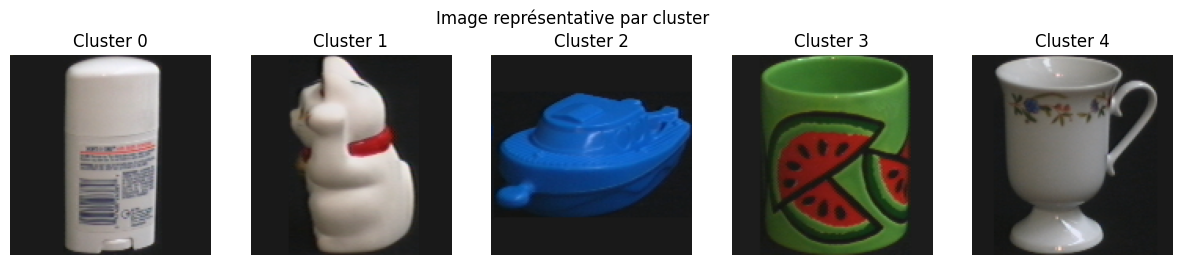

In [27]:
display_cluster_examples("features.npz", n_clusters=5, base_folder="coil-100")


le resultat affiche une image par cluster, ce qui donne un aperçu visuel de la répartition des groupes selon couleur + forme.

Étape 4 – Afficher plusieurs images par cluster (grille)

In [28]:
def display_cluster_grids(features_file="features.npz", n_clusters=5, base_folder="coil-100", max_per_cluster=6):
    filenames, hists, hus = load_features(features_file)
    combined = np.hstack([hists, hus])
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(combined)

    # Groupons les fichiers par cluster
    cluster_to_files = {i: [] for i in range(n_clusters)}
    for fname, label in zip(filenames, kmeans.labels_):
        if len(cluster_to_files[label]) < max_per_cluster:
            cluster_to_files[label].append(fname)

    # Affichage des clusters
    for cluster_id, files in cluster_to_files.items():
        plt.figure(figsize=(15, 3))
        plt.suptitle(f"Cluster {cluster_id} – {len(files)} images")
        for i, fname in enumerate(files):
            img_path = os.path.join(base_folder, fname)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(1, max_per_cluster, i + 1)
            plt.imshow(img_rgb)
            plt.title(fname)
            plt.axis('off')
        plt.show()


Test sur 5 clusters

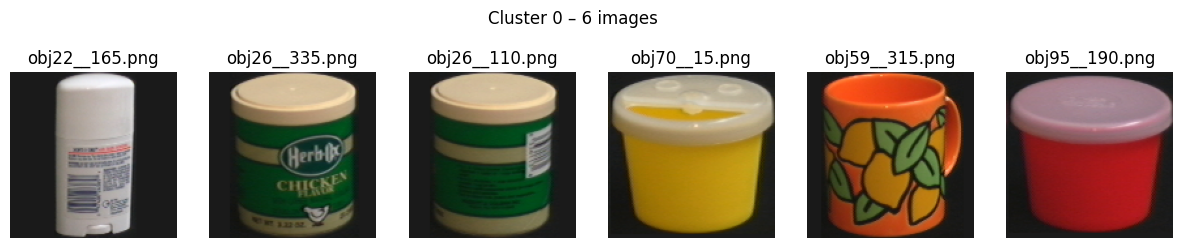

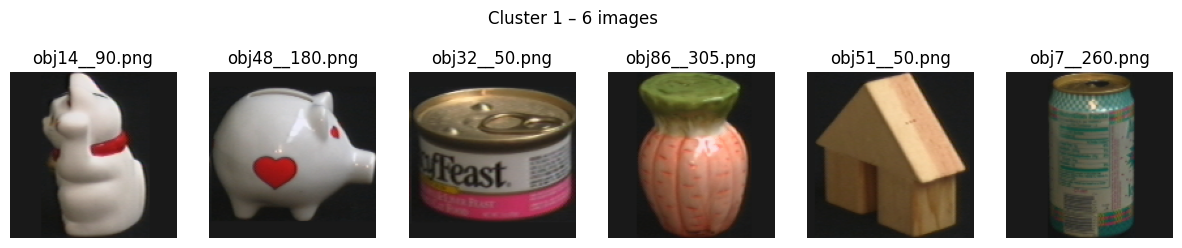

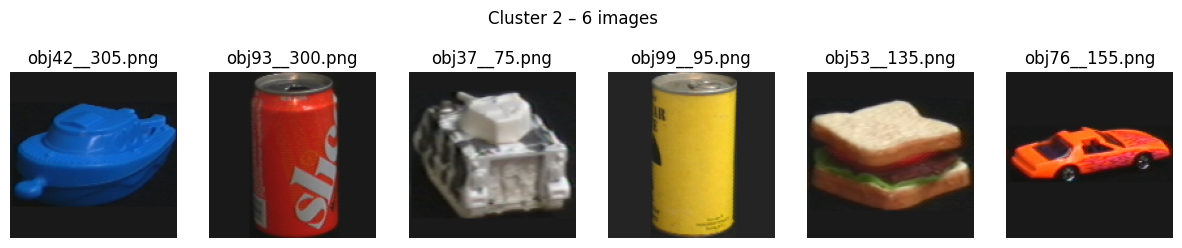

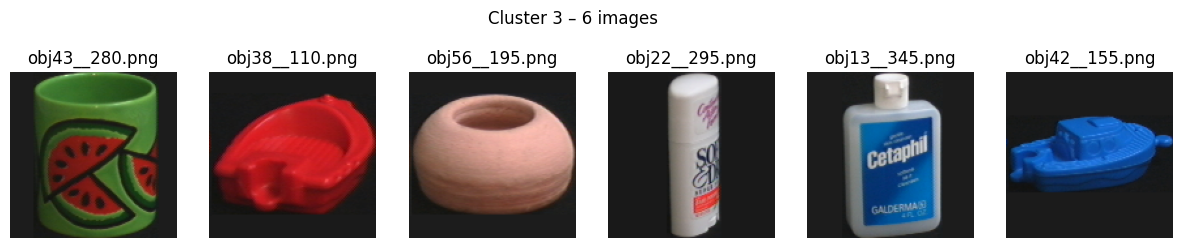

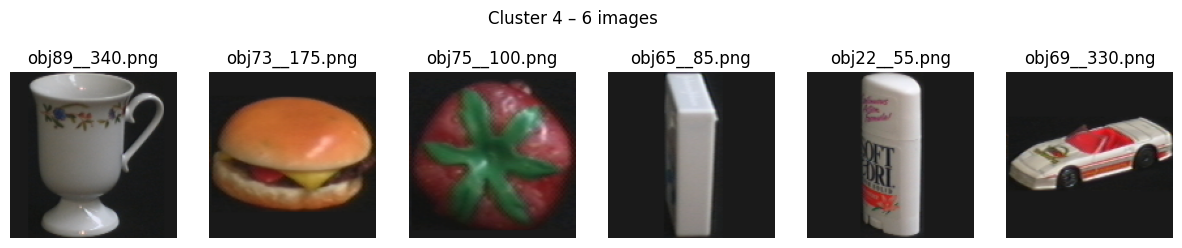

In [29]:
display_cluster_grids("features.npz", n_clusters=5, base_folder="coil-100", max_per_cluster=6)


on teste ici 6 images par cluster, pour comparer leur similarité visuelle (forme et couleur).

# À partir d’une image requête, trouver à quel cluster elle appartient et montrer les images les plus proches dans ce cluster.

 Étape 1 – Charger les clusters et leurs centroïdes

In [30]:
def load_kmeans_model(features_file="features.npz", n_clusters=5):
    filenames, hists, hus = load_features(features_file)
    combined = np.hstack([hists, hus])
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(combined)
    return filenames, combined, kmeans


Étape 2 – Prédire le cluster d’une image requête

In [31]:
def find_similar_in_cluster(query_path, features_file="features.npz", n_clusters=5, base_folder="coil-100", top_k=5):
    filenames, combined, kmeans = load_kmeans_model(features_file, n_clusters)

    # Extraction des features de l'image requête
    feats = extract_features(query_path)
    query_vector = np.hstack([feats["hist"], feats["hu"]])

    # on trouve  le cluster de l'image requête
    cluster_id = kmeans.predict([query_vector])[0]
    print(f"L'image requête appartient au cluster : {cluster_id}")

    # on trouve  les fichiers dans le même cluster
    cluster_indices = [i for i, lbl in enumerate(kmeans.labels_) if lbl == cluster_id]
    cluster_vectors = combined[cluster_indices]
    cluster_files = [filenames[i] for i in cluster_indices]

    # Calcule de la distance entre l'image requête et les images du même cluster
    dists = [np.linalg.norm(query_vector - vec) for vec in cluster_vectors]
    sorted_indices = np.argsort(dists)

    # Affichage des images les plus proches
    plt.figure(figsize=(15, 3))
    plt.suptitle("Images similaires dans le même cluster")

    for i in range(min(top_k, len(sorted_indices))):
        idx = sorted_indices[i]
        fname = cluster_files[idx]
        path = os.path.join(base_folder, fname)
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, top_k, i + 1)
        plt.imshow(img_rgb)
        plt.title(f"{fname}\nDist: {dists[idx]:.2f}")
        plt.axis('off')

    plt.show()


le resultat doit Affiche :
- dans quel cluster se trouve l’image requête
- les images les plus proches dans ce cluster
- Donner leur distance visuelle

L'image requête appartient au cluster : 3


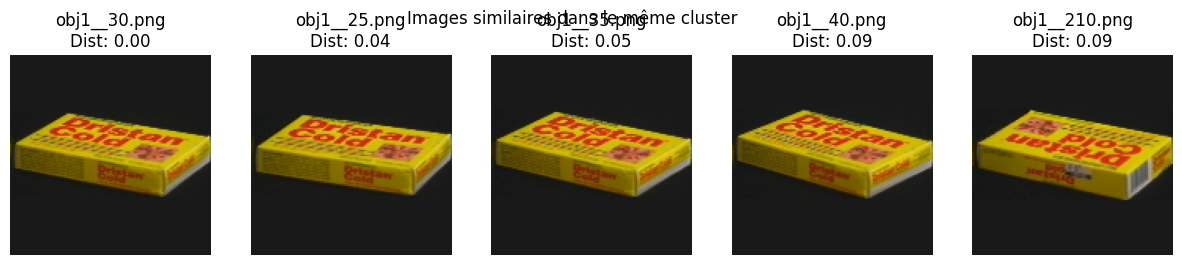

In [32]:
find_similar_in_cluster("coil-100/obj1__30.png", n_clusters=5)


Le resultat  :

j'ai soumis obj1__30.png comme image requête. Elle a été classée dans le cluster 3 et Les 5 images les plus proches dans ce cluster sont :
        obj1__25.png
        obj1__35.png
        obj1__40.png
        obj1__210.png
Les distances sont faibles (entre 0.00 et 0.09), ce qui signifie une forte similarité.

Visuellement :

Toutes les images montrent le même objet, vu sous des angles légèrement différents qui est donc l'objectif principale de retrouver des images similaires par forme et couleur 

nous testons avec un autre image voir comment cela reagis 

L'image requête appartient au cluster : 2


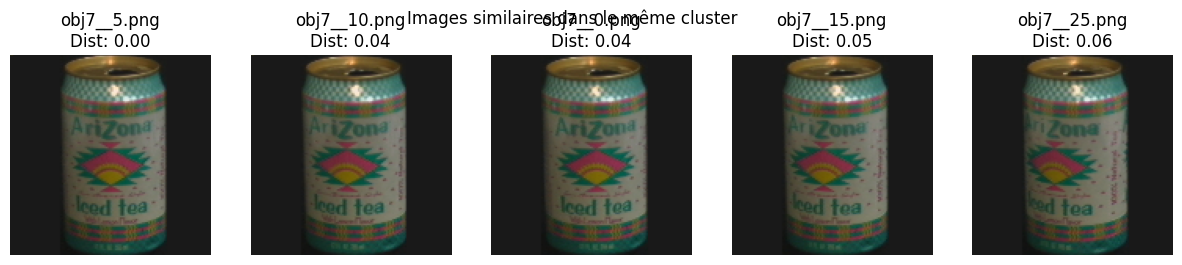

In [33]:
find_similar_in_cluster("coil-100/obj7__5.png", n_clusters=5)

on remarque :
l'image a été classée dans le cluster 2 et Les 5 images les plus proches sont aussi des vues différentes du même objet, Les distances sont très faibles (de 0.00 à 0.06), donc la forme + la couleur sont très proches

# Afficher un graphique des clusters avec PCA afin de visualiser chaque classe (cluster) dans un graphique 2D en réduisant les descripteurs (couleur + forme) à deux dimensions.

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_clusters_2D(features_file="features.npz", n_clusters=5):
    filenames, hists, hus = load_features(features_file)
    combined = np.hstack([hists, hus])
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(combined)
    
    # Réduction en 2D avec PCA
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(combined)

    # Tracer chaque point avec la couleur du cluster
    plt.figure(figsize=(10, 6))
    for i in range(n_clusters):
        cluster_points = reduced[kmeans.labels_ == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i}", s=30)

    plt.title("Visualisation 2D des clusters (PCA)")
    plt.xlabel("Composante 1")
    plt.ylabel("Composante 2")
    plt.legend()
    plt.grid(True)
    plt.show()


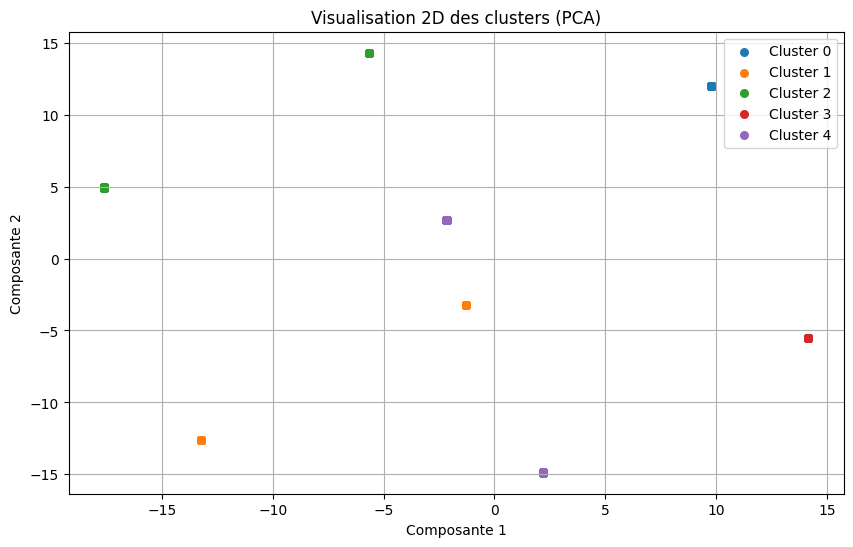

In [54]:
visualize_clusters_2D("features.npz", n_clusters=5)


Interpretation :
- Chaque point représente une image.
- Les couleurs représentent les clusters attribués par KMeans.
- On vois que  certains groupes sont bien séparés (ex. cluster 3 en bas à droite), ce qui montre que leurs descripteurs (forme + couleur) sont très différents.
- D'autres clusters semblent un peu plus proches (clusters 1 et 4 par exemple), ce qui peut indiquer des similarités visuelles partielles.

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_descriptors_tsne(features_file="features.npz", n_clusters=5):
    filenames, hists, hus = load_features(features_file)
    combined = np.hstack([hists, hus])
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(combined)

    # Réduction t-SNE en 2D
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
    reduced = tsne.fit_transform(combined)

    # Affichage des points avec couleur de cluster
    plt.figure(figsize=(10, 6))
    for i in range(n_clusters):
        cluster_points = reduced[kmeans.labels_ == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i}", s=30)

    plt.title("t-SNE des descripteurs d'images (couleur + forme)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.grid(True)
    plt.show()


/home/priscille/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


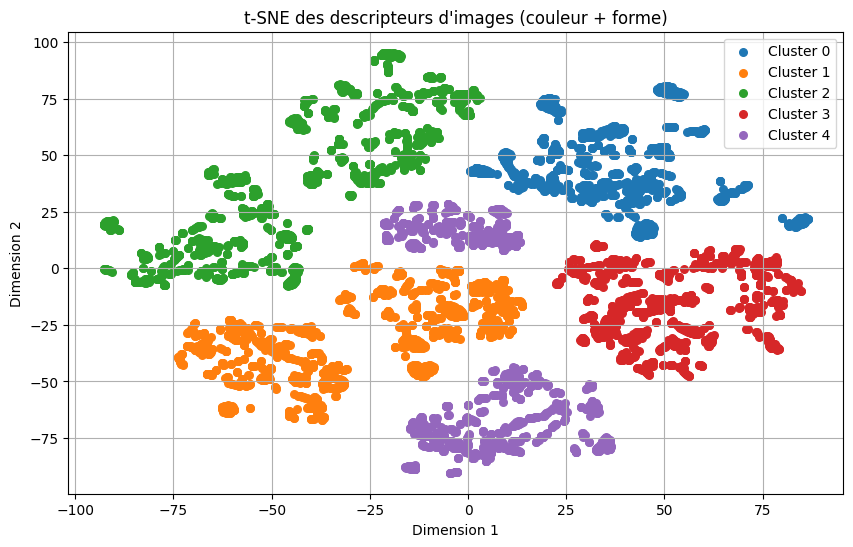

In [36]:
visualize_descriptors_tsne("features.npz", n_clusters=5)


----------------------------------------------------------------------------------------------------------------

# Résumé des résultats avec KMeans

Dans la seconde partie du TP, nous avons appliqué l’algorithme KMeans sur les descripteurs d’images extraits (couleur + forme) afin de regrouper automatiquement les images similaires de la base COIL-100.
- Ce que nous avons fait :

    Fusion des descripteurs d’histogrammes RVB (96 valeurs) et des moments de Hu (7 valeurs) pour chaque image.

    Application de KMeans (k=5) pour regrouper les images en 5 clusters.

    Visualisation 2D des clusters obtenus à l’aide de PCA, pour évaluer la séparation.

    Affichage d’images représentatives de chaque cluster.

    Implémentation d’un système de recherche dans le cluster le plus proche à partir d’une image requête.

- Résultats observés :

    Les images ont été regroupées de manière cohérente selon leur couleur dominante et leur forme.

    Exemple : les images d’une même boîte ou d’une canette ont été rassemblées même vues sous différents angles.

    Le clustering a permis de réduire l’espace de recherche en limitant la comparaison à un seul cluster.

    La recherche d’images similaires dans un même cluster a montré des distances faibles, témoignant d’une bonne cohérence intra-cluster.